In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import register_matplotlib_converters
from copy import deepcopy
import qiskit
from qiskit import transpile
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import NumPyMinimumEigensolver, VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, RealAmplitudes, PauliTwoDesign
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import YahooDataProvider
from qiskit.result import QuasiDistribution
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Session as RSession#, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# from qiskit.quantum_info import SparsePauliOp, Pauli
from docplex.mp.advmodel import AdvModel
from qiskit_aer.noise import NoiseModel

In [2]:
seed = 1093284
algorithm_globals.random_seed = seed
register_matplotlib_converters()
service = QiskitRuntimeService(channel="ibm_quantum",token="b15a93acddcd3a1ed603f13943865c12a46d987851ccddae151a1ce1edeed1bc03c0de6e9c148fea11fcad5338e09df0a0a25ce32abfa17e5ff5fd85d52113f9")

In [3]:
from typing import Dict
import mitiq.executor
from qiskit_ibm_runtime.ibm_backend import IBMBackend
from qiskit_ibm_runtime.options.estimator_options import EstimatorOptions
from qiskit_ibm_runtime.session import Session

class UDS_QEM_Estimator(EstimatorV2):
    def __init__(self, backend: str | IBMBackend | None = None, session: Session | None = None, options: Dict | EstimatorOptions | None = None):
        super().__init__(backend, session, options)

In [4]:
from collections.abc import Callable
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit_algorithms import AlgorithmError

class ModVQE(VQE):
    def _get_evaluate_energy(
            self,
            ansatz: QuantumCircuit,
            operator: BaseOperator,
        ) -> Callable[[np.ndarray], np.ndarray | float]:
            """Returns a function handle to evaluate the energy at given parameters for the ansatz.
            This is the objective function to be passed to the optimizer that is used for evaluation.

            Args:
                ansatz: The ansatz preparing the quantum state.
                operator: The operator whose energy to evaluate.

            Returns:
                A callable that computes and returns the energy of the hamiltonian of each parameter.

            Raises:
                AlgorithmError: If the primitive job to evaluate the energy fails.
            """
            num_parameters = ansatz.num_parameters

            # avoid creating an instance variable to remain stateless regarding results
            eval_count = 0

            def evaluate_energy(parameters: np.ndarray) -> np.ndarray | float:
                nonlocal eval_count

                # handle broadcasting: ensure parameters is of shape [array, array, ...]
                parameters = np.reshape(parameters, (-1, num_parameters)).tolist()
                # batch_size = len(parameters)

                try:
                    job = self.estimator.run([(ansatz, operator, parameters)])
                    estimator_result = job.result()
                except Exception as exc:
                    raise AlgorithmError("The primitive job to evaluate the energy failed!") from exc

                values = estimator_result.values

                if self.callback is not None:
                    metadata = estimator_result.metadata
                    for params, value, meta in zip(parameters, values, metadata):
                        eval_count += 1
                        self.callback(eval_count, params, value, meta)

                energy = values[0] if len(values) == 1 else values

                return energy

            return evaluate_energy

In [5]:
num_assets = 4
stocks = ["AAPL","IBM","NFLX","TSLA"]

In [6]:
def print_result(result, qubo):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = qubo.objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        pub = (ansatz, [hamiltonian], [current_vector])
        result = estimator.run(pubs=[pub]).result()
        current_cost = result[0].data.evs[0]
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    return energy

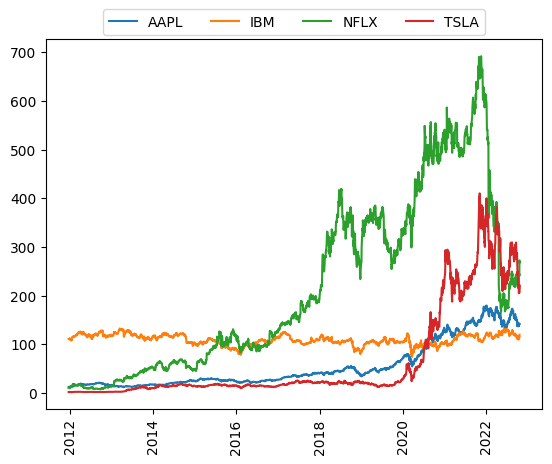

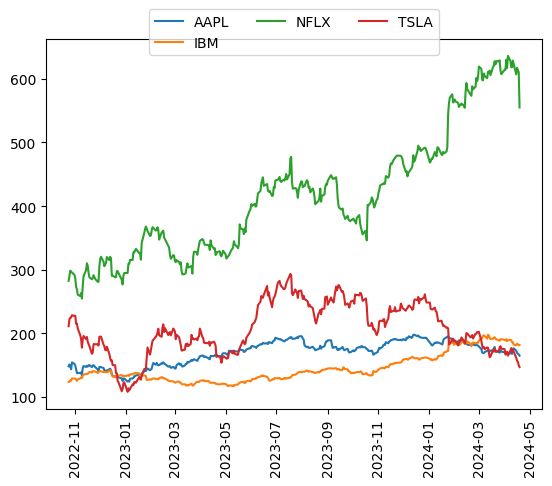

In [7]:
try:
    tr_data = YahooDataProvider(
            tickers=stocks,
            start=datetime.datetime(2011, 12, 23),
            end=datetime.datetime(2022, 10, 21),
        )
    tr_data.run()

    for (cnt, s) in enumerate(tr_data._tickers):
        plt.plot(tr_data._data[cnt], label=s)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=4)
    plt.xticks(rotation=90)
    plt.show()
    # plt.savefig("Training data for VQE w/ QEM.png")
    
except QiskitFinanceError as ex:
    print(ex)
    print("Error retrieving data.")
    
try:
    te_data = YahooDataProvider(
        tickers=stocks,
        start=datetime.datetime(2022, 10, 22),
        end=datetime.datetime(2024, 4, 20),
    )
    te_data.run()

    for (cnt, s) in enumerate(te_data._tickers):
        plt.plot(te_data._data[cnt], label=s)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xticks(rotation=90)
    plt.show()
    # plt.savefig("Training data for VQE w/ QEM")
except QiskitFinanceError as ex:
    print(ex)
    print("Error retrieving data.")

In [9]:
tr_data._data[0]

Date
2011-12-23     12.194966
2011-12-27     12.291718
2011-12-28     12.174099
2011-12-29     12.249085
2011-12-30     12.245457
                 ...    
2022-10-14    137.207840
2022-10-17    141.203705
2022-10-18    142.532379
2022-10-19    142.641418
2022-10-20    142.175400
Name: Adj Close, Length: 2724, dtype: float64

In [8]:
out_data = pd.DataFrame()
for i,data in enumerate(tr_data._data):
    out_data[tr_data._tickers[i]] = data
out_data.to_csv('train_ticker_data.csv')
out_data = pd.DataFrame()
for i,data in enumerate(te_data._data):
    out_data[te_data._tickers[i]] = data
out_data.to_csv('test_ticker_data.csv')

Optimization Problem Setup

is basic rn, change to paper

and then after isinstance(quadratic optimization)
convert to Quadratic Unconstrained Binary Optimization (QUBO) problem,

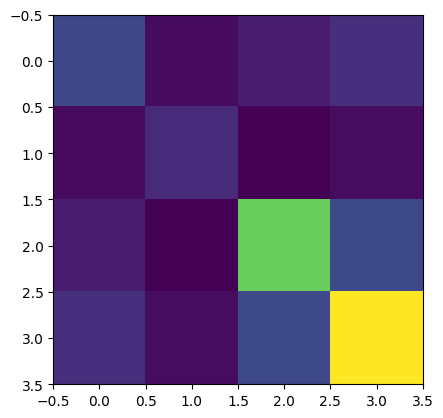

In [9]:
P = np.asarray(tr_data._data)[:,-1]
mu = tr_data.get_period_return_mean_vector()
sigma = tr_data.get_period_return_covariance_matrix()
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [12]:
print([1000, 1245,3103, 13450])
print(np.ceil(np.log2([1000, 1245,3103, 13450])))


[1000, 1245, 3103, 13450]
[10. 11. 12. 14.]


In [10]:
q = 0.5  # set risk factor
budget = 2000  # set budget
penalty = 10

qp = AdvModel('portfolio_optimization')
n_max = np.floor(budget/P) #  (8)
d = np.floor(np.log2(n_max)).astype(int) #ep (9)of binarizing elements di for each asset i depending on the price
dim_b = sum(d+1) #overall dimension of binarized target vector b

p_prime = P/budget # investment i as fraction of budget
mu_p = p_prime * mu #\mu'
sigma_p = (p_prime * sigma).T * p_prime #\Sigma'

C = []
for i,val in enumerate(d):
    row = np.zeros(dim_b)
    row[sum(d[:i]) + i:sum(d[:i+1]) + i + 1] = [2 ** j for j in range(val+1)]
    C.append(row)
C = np.array(C) #eq (11)

mu_p2 = C.T @ mu_p 
sigma_p2 = C.T @ sigma_p @ C 
p_prime2 = C.T @ p_prime

#bin var n - num shares per asset, to get the number of 
bin_vars = []
for i in range(len(P)):
    for j in range(d[i]+1):
        bin_vars.append(qp.binary_var(f"b_{i}_{j}"))

lin = np.dot(mu_p2,bin_vars)
quad = q * qp.quad_matrix_sum(sigma_p2,bin_vars,True)
qp.maximize(lin - quad)

constraint = np.dot(p_prime2,bin_vars)
qp.linear_constraint(constraint, ctsense='eq', rhs=1)
qp = from_docplex_mp(qp)
qubo = LinearEqualityToPenalty(penalty).convert(qp) #Eq. 14
ham, ham_constant = qubo.to_ising()#Eq. 16
print('Hamiltonian constant: ',ham_constant)

Hamiltonian constant:  -0.002038630409050318


Classical Simulator

In [14]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
qp = deepcopy(qubo)
result = exact_eigensolver.solve(qp)
print_result(result,qp)

Optimal: selection [1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1.], value 0.0032

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1]	0.0032		1.0000


Quantum Simulator

In [15]:
print(service.backends())

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('ibm_sherbrooke')>]


In [12]:
real_backend = service.backend("ibm_sherbrooke")

In [90]:
noise_model = NoiseModel.from_backend(real_backend)
coupling_map: qiskit.transpiler.coupling.CouplingMap = real_backend.coupling_map

In [18]:
print(real_backend.target)

Target
Number of qubits: 127
Instructions:
	id
		(0,):
			Duration: 5.6888888888888887e-08 sec.
			Error Rate: 0.0005413602514984257
			With pulse schedule calibration
		(1,):
			Duration: 5.6888888888888887e-08 sec.
			Error Rate: 0.0001577762633664345
			With pulse schedule calibration
		(2,):
			Duration: 5.6888888888888887e-08 sec.
			Error Rate: 0.00018912066402665588
			With pulse schedule calibration
		(3,):
			Duration: 5.6888888888888887e-08 sec.
			Error Rate: 0.000540808574495539
			With pulse schedule calibration
		(4,):
			Duration: 5.6888888888888887e-08 sec.
			Error Rate: 0.00046655176811527
			With pulse schedule calibration
		(5,):
			Duration: 5.6888888888888887e-08 sec.
			Error Rate: 0.0003186990735953224
			With pulse schedule calibration
		(6,):
			Duration: 5.6888888888888887e-08 sec.
			Error Rate: 0.00030337568484779196
			With pulse schedule calibration
		(7,):
			Duration: 5.6888888888888887e-08 sec.
			Error Rate: 0.00026124739134166067
			With pulse schedu

In [19]:
# aer = QasmSimulator(target=real_backend.target,method='density_matrix',noise_model=noise_model,max_memory_mb=16384)
# aer.set_option('coupling_map',coupling_map)
# aer.set_max_qubits(ham.num_qubits)
# aer = QasmSimulator.from_backend(real_backend)
aer = AerSimulator.from_backend(real_backend)
pm = generate_preset_pass_manager(backend=aer, optimization_level=3)

In [32]:
def transpile_given_ansatz(ansatz):
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = ham.apply_layout(layout=ansatz_isa.layout)
    return ansatz_isa, hamiltonian_isa
cobyla = COBYLA(maxiter=200)

In [73]:
qasm_backend = service.backend('ibmq_qasm_simulator')

In [91]:
coupling_map = coupling_map.reduce(list(range(0,17)))

In [ ]:
noise_model.add_basis_gates([])

In [135]:
qasm_sim = AerSimulator(target=qasm_backend.target,method='stabilizer',coupling_map=coupling_map)#,noise_model=noise_model)

In [136]:
two_local_ansatz = TwoLocal(ham.num_qubits, "rz", "cz", reps=3, entanglement="linear")
params = 2 * np.pi * np.random.rand(two_local_ansatz.num_parameters) - np.pi
# ansatz_isa_2L, hamiltonian_isa_2L = transpile_given_ansatz(two_local_ansatz)
twoL_isa = transpile(two_local_ansatz,qasm_sim)

In [137]:
ham_2L = ham.apply_layout(layout=twoL_isa.layout)
# ansatz_isa_2L.draw(output='mpl',idle_wires=False,style='iqp')

In [127]:
print(twoL_isa.num_qubits)
print(ham_2L.num_qubits)

32
32


In [130]:
print(NoiseModel())

NoiseModel:
  Basis gates: ['delay', 'ecr', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['x', 'id', 'sx', 'reset', 'ecr', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [ ]:
pauli_two = PauliTwoDesign(ham.num_qubits, seed=seed)
params = 2 * np.pi * np.random.rand(pauli_two.num_parameters) - np.pi
ansatz_isa_P2, hamiltonian_isa_P2 = transpile_given_ansatz(pauli_two)

In [116]:
def run_test(ansatz,ham,params,estimator):
    callback_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }
    energies = []
    callback = build_callback(ansatz, ham, estimator, callback_dict)
    vqe_mes = ModVQE(estimator, ansatz, optimizer=cobyla, callback=callback, initial_point=params)
    for _ in range(2000):
        result = vqe_mes.compute_minimum_eigenvalue(operator=ham)
        vqe_mes = ModVQE(estimator, ansatz, optimizer=cobyla, callback=callback, initial_point=result.optimal_point)
        energies.append(result.eigenvalue.real) 
        

    average_energy = sum(energies) / len(energies)
    print('Average minimum energy over 2000 runs:', average_energy)
    return energies#, callback

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
# ax.set_xlabel("Iterations")
# ax.set_ylabel("Cost")
# plt.draw()
estimator = Estimator(options={'backend_options':{"target":qasm_backend.target,'noise_model':noise_model}})
energies,_ = run_test(twoL_isa,ham_2L,params,estimator)
plt.hist(energies, bins=50)
plt.title('Energy Distribution over 2000 VQE Runs')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
# ax.set_xlabel("Iterations")
# ax.set_ylabel("Cost")
# plt.draw()
noise_model = NoiseModel.from_backend(real_backend)
estimator = Estimator(backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    })
energies,_ = run_test(ansatz_isa_2L,hamiltonian_isa_2L,params,estimator)
plt.hist(energies, bins=50)
plt.title('Energy Distribution over 2000 VQE Runs')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.show()

In [ ]:
ansatz_isa.draw(output='mpl',idle_wires=False,style='iqp')

Real Quantum Device

In [41]:
two_local_ansatz = TwoLocal(ham.num_qubits, "ry", "cz", reps=3, entanglement="linear")
params = 2 * np.pi * np.random.rand(two_local_ansatz.num_parameters) - np.pi
ansatz_isa_2L, hamiltonian_isa_2L = transpile_given_ansatz(two_local_ansatz)
with Session(backend=real_backend) as session:
    estimator = EstimatorV2(session=session)
    energies,_ = run_test(ansatz_isa_2L,hamiltonian_isa_2L,params,estimator)
plt.hist(energies, bins=50)
plt.title('Energy Distribution over 2000 VQE Runs')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.show()